### Install all imports 

In [50]:
import openpyxl as op
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
import numpy as np
import pandas as pd
from openpyxl import Workbook
import re
from IPython.display import set_matplotlib_formats
import collections
import plotly.graph_objects as go
import os
import glob
import plotly.express as px
import statistics

### Concatenate all hybrid alignment output tables

In [23]:
os.chdir("../B_hybrid_aln_results_toy/cblock-tables/")
extension = 'tsv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
print(all_filenames)

FileNotFoundError: [Errno 2] No such file or directory: '../B_hybrid_aln_results_toy/cblock-tables/'

In [10]:
# writes a new excel file to the same directory
# out_path = r"../C_toy_plots/"
#writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
writer = pd.ExcelWriter('merged_file.xlsx', engine='xlsxwriter')
for i, file in enumerate(all_filenames):
    df = pd.read_csv(file, sep="\t")
    df.to_excel(writer, sheet_name=str(all_filenames[i]))
 
writer.save()

### Create intermediate tables for plotting

In [16]:
# Load all files
wb = op.load_workbook(r'merged_file.xlsx')
xls = pd.ExcelFile('merged_file.xlsx')
writer = pd.ExcelWriter('intermediate.xlsx', engine='xlsxwriter')

sheet_count = len(xls.sheet_names)
append_data = []

for i in range(0, sheet_count):
#     sheet = xls.parse(i)
    cols=[1,2,9,10,19,20]
    data = pd.read_excel(xls,i, usecols=cols)
    append_data.append(data)
    
   
append_data = pd.concat(append_data)   

append_data.to_excel(writer, sheet_name='Sheet1')
writer.save()
writer.close()

df = pd.read_excel('intermediate.xlsx')
df['Unnamed: 0'] = df['anchor']
df.columns = df.columns.str.replace('Unnamed: 0', 'gene')
df['gene'] = df.gene.str.extract('(.*?)-', expand=False)
df['s-pblock_subcat']=0
df.to_excel(r'intermediate_2.xlsx', index=False)

In [24]:
# Modify intermediate table number 2
df = pd.read_excel('intermediate_2.xlsx')
df.head()
wb_i = op.load_workbook(r'intermediate_2.xlsx')
sheet_i=wb_i.active

c_rid =False
c_re=False
r=1

for i in range(2, sheet_i.max_row):
    c1_iso, c2_iso = sheet_i.cell(row=i, column=3), sheet_i.cell(row=i+1, column=3)
    c1_pb, c2_pb = sheet_i.cell(row=i, column=4), sheet_i.cell(row=i+1, column=4)
    c1_cb, c2_cb = sheet_i.cell(row=i, column=5), sheet_i.cell(row=i+1, column=5)
    if c1_iso.value == c2_iso.value:
        if c1_pb.value == c2_pb.value:
            #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            if str(c1_cb.value).startswith("d") or str(c2_cb.value).startswith("d") or str(c1_cb.value).startswith("i") or str(c2_cb.value).startswith("i"):
                c_rid = True
            
            if str(c1_cb.value).startswith("e") or str(c2_cb.value).startswith("e"):
                c_re = True  
            r+=1

        else:
            if (c_rid == True and c_re == True):
                if str(c1_pb.value).startswith("S"):
                    #print(c1_pb.value, r)
                    for k in range(0, r):
                        sheet_i.cell(row=i-k, column=8).value = "ragged_S"
            c_rid =False
            c_re=False
            r=1

    else:
        if (c_rid == True and c_re == True):
            if str(c1_pb.value).startswith("S"):
                #print(c1_pb.value, r)
                for k in range(0, r):
                    sheet_i.cell(row=i-k, column=8).value = "ragged_S"



        c_rid =False
        c_re=False
        r=1
sheet_i.delete_cols(5)
wb_i.save('intermediate_2.xlsx')

### Plot 1: Number of isoforms vs count of splice events affecting protein region plot
Plot how many protein regions (pblocks) are affected by splicing per isoform. 

In [36]:
wb = op.load_workbook(r'merged_file.xlsx')

In [37]:
# Dictionaries to store count of affected protein regions or pblocks
pb_stats = {1:0, 2:0,3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0, 11:0, 12:0, 13:0, 14:0, 15:0, 23:0, 28:0, 36:0}

#Loop through sheets to populate the dictionary
for sh in wb.worksheets:
    #Variables to keep tarck of count
    count=1

    #Loop through rows of a sheet (excludes header)
    for i in range(2, sh.max_row):
        # Alt isoform values for 2 cells to compare
        c1_iso, c2_iso = sh.cell(row=i, column=2), sh.cell(row=i+1, column=2)
        # Pblock values for 2 cells to compare
        c1_pb, c2_pb = sh.cell(row=i, column=9), sh.cell(row=i+1, column=9)
        #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # Both cells have same isoforms
        if c1_iso.value == c2_iso.value:
            # Have different pblocks
            if c1_pb.value != c2_pb.value:
                #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                count+=1
            
        #When isoforms are different
        else:
            # # To get isoforms with extreme values
            # if count > 10:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

            # Updating count
            pb_stats[count]+=1
            count=1
    
            # pblocks shared between two different transcripts
            # if c1_pb.value == c2_pb.value:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            #print(count)
        
        #print(pb_stats,'\n')

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/3695465104.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


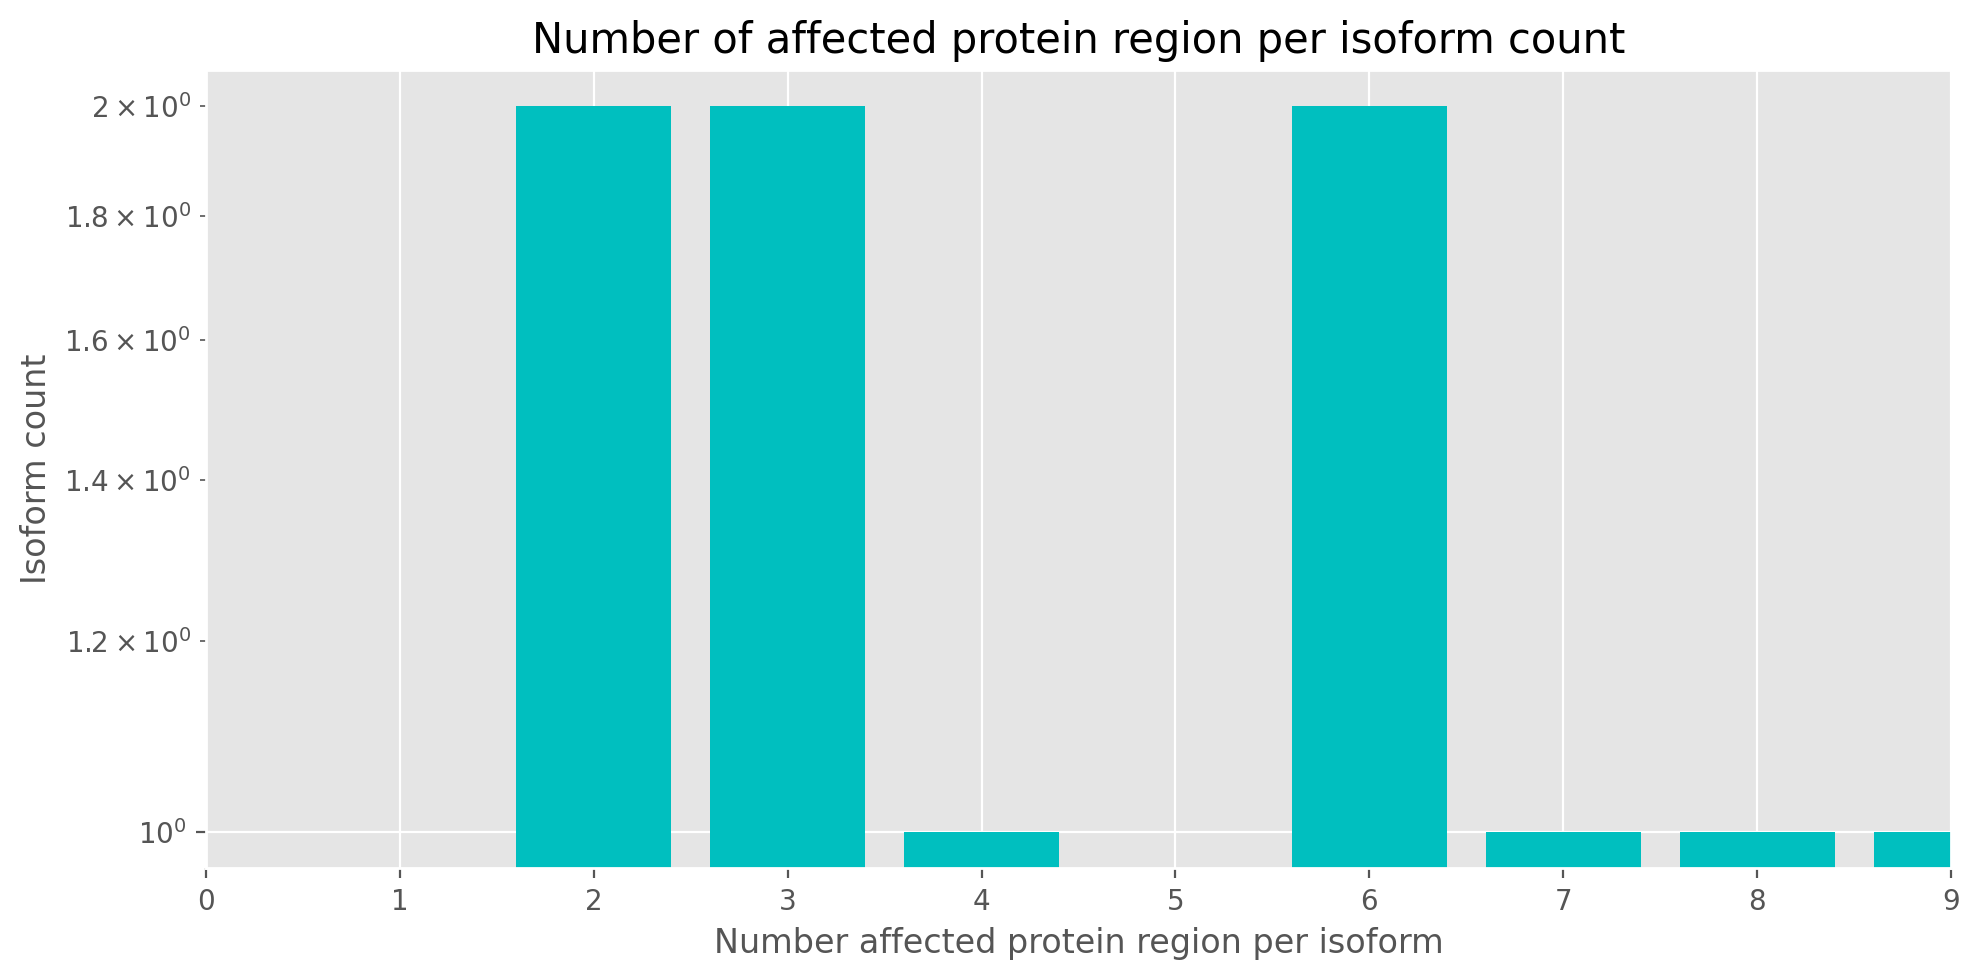

In [47]:

set_matplotlib_formats('retina', quality=1200)

plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')

plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0, 9)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Number affected protein region per isoform')
plt.ylabel('Isoform count')
plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(pb_stats.keys(), pb_stats.values(), width=0.8, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_count_histogram.png',dpi=1200)


### Plot 2: Size of affected protein regions vs number of isoform aggregate plot
To see what's the size of the pblocks being affected per isoform


In [55]:
wb = op.load_workbook(r'merged_file.xlsx')

In [56]:

pb_stats_size = []

def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        # print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
        size = res[3]-res[2]
    pb_stats_size.append(size)
    return 0

for sh in wb.worksheets:


    for i in range(2, sh.max_row):
        c1_ref = sh.cell(row=i, column=2)
        c2_ref =sh.cell(row=i, column=2)
        c1_iso = sh.cell(row=i, column=3)
        c2_iso = sh.cell(row=i+1, column=3)
        c1_pb = sh.cell(row=i, column=10)
        c2_pb = sh.cell(row=i+1, column=10)
        #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # When iso are same
        if c1_iso.value == c2_iso.value:
            if c1_pb.value != c2_pb.value:
                #pblock is different for the iso
                #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                
                getsize(c1_pb.value, sh, c1_iso.value)

        
            #else:
                #print("Same pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                #print(count)
            
        #When iso are different
        else: 
            getsize(c1_pb.value, sh, c1_iso.value)
    
            
            # pblocks shared between two different transcripts
            # if c1_pb.value == c2_pb.value:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            #print(count)
        
        #print(pb_stats,'\n')

152.42434210526315
47.0


/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/2663265170.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)


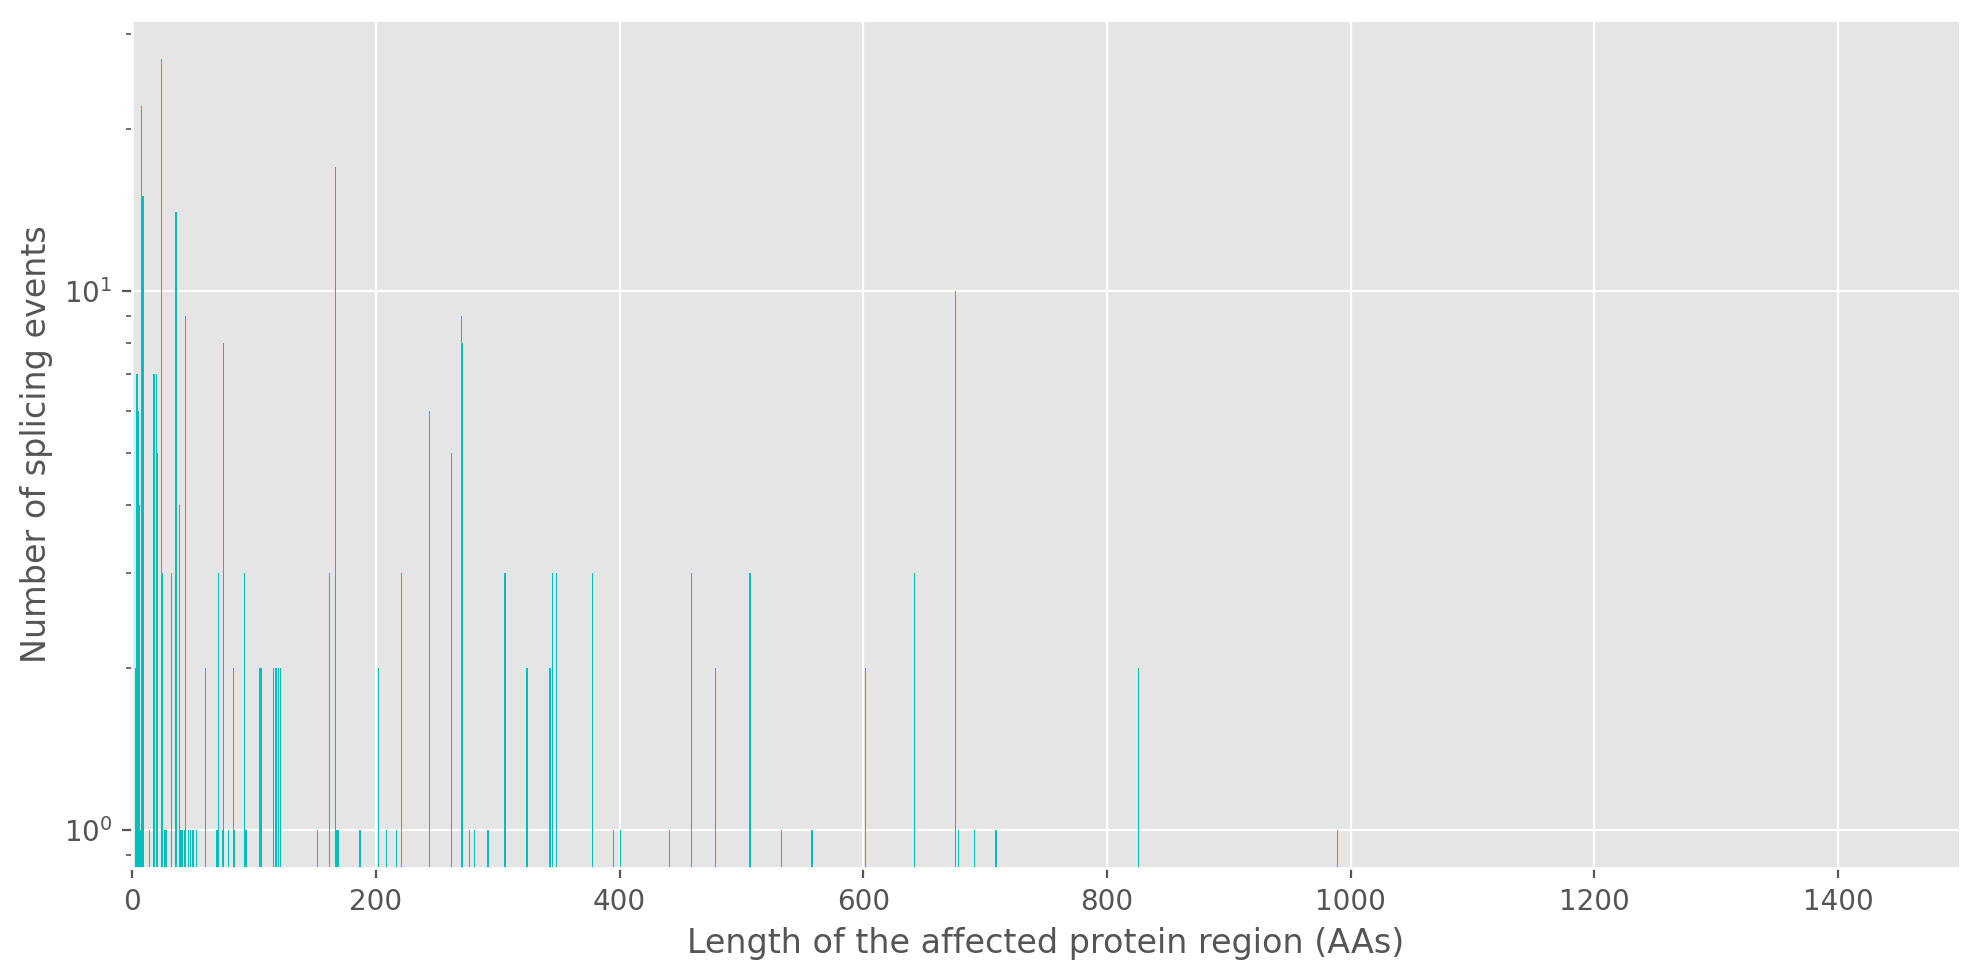

In [57]:
counter = collections.Counter(pb_stats_size)
#counter=sorted(counter.items())

#print(counter)
x1 = list(counter.keys())
y1 = list(counter.values())

average_size = sum(pb_stats_size)/len(pb_stats_size)
print(average_size)
print(statistics.median(pb_stats_size))

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
#plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
#plt.title('Number of affected protein region per isoform count', fontsize=15)
plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram.png',dpi=1200)


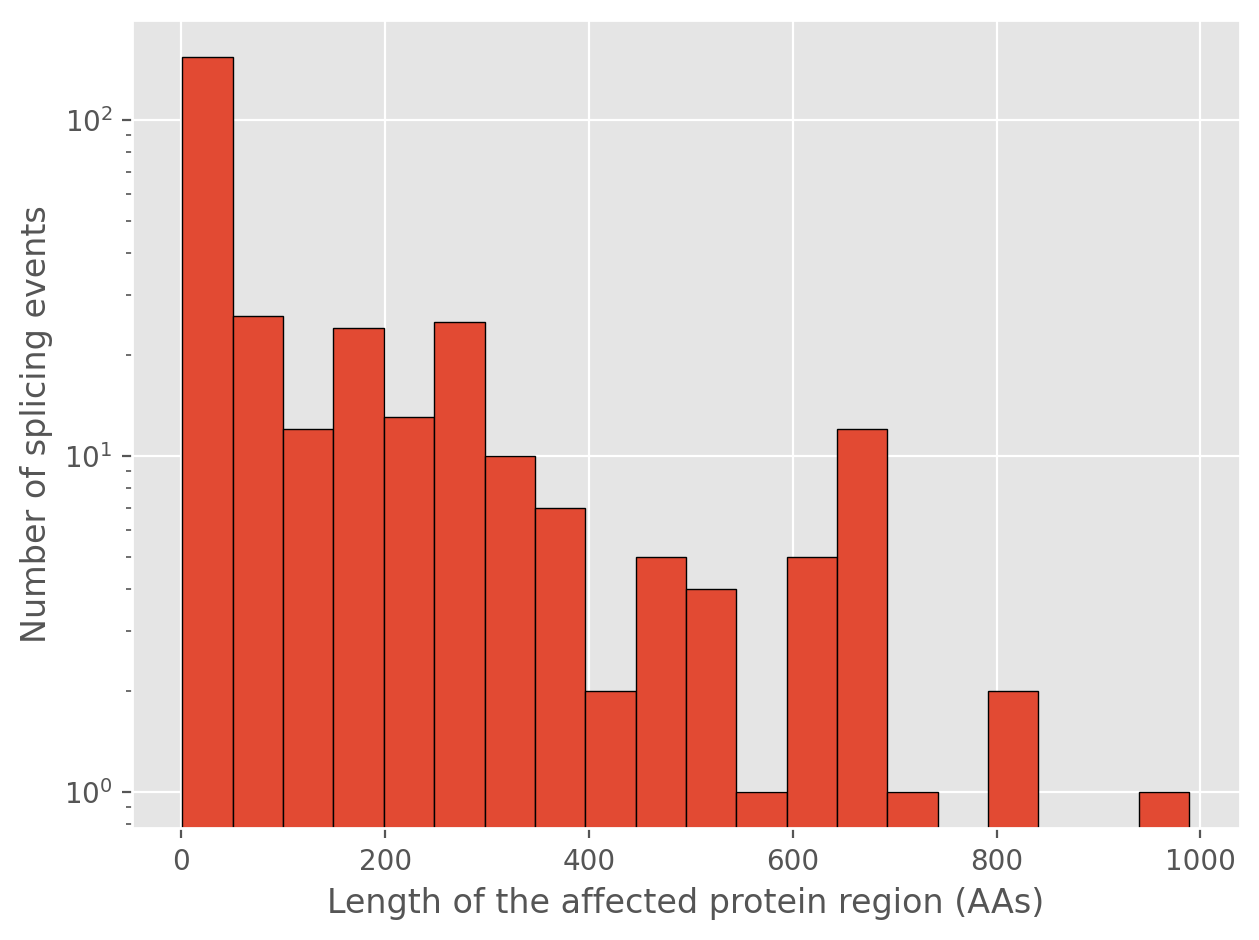

In [67]:
plt.hist(pb_stats_size, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 3: Size of affected protein regions vs number of isoform aggregate plot for Insertion splicing event
To see what's the size of the pblocks being affected per isoform


In [58]:
wb = op.load_workbook(r'merged_file.xlsx')

In [59]:
pb_stats_size_I=[]


def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        # print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
        size = res[3]-res[2]
    if c1_pb_val.startswith("I"):
        pb_stats_size_I.append(size)
    #print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
    return 0

for sh in wb.worksheets:
 
    for i in range(2, sh.max_row):
        c1_ref = sh.cell(row=i, column=2)
        c2_ref =sh.cell(row=i, column=2)
        c1_iso = sh.cell(row=i, column=3)
        c2_iso = sh.cell(row=i+1, column=4)
        c1_pb = sh.cell(row=i, column=10)
        c2_pb = sh.cell(row=i+1, column=10)
        #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # When iso are same
        if c1_iso.value == c2_iso.value:
            if c1_pb.value != c2_pb.value:
                #pblock is different for the iso
                #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                getsize(c1_pb.value, sh, c1_iso.value)
        
            #else:
                #print("Same pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                #print(count)
            
        #When iso are different
        else: 
            getsize(c1_pb.value, sh, c1_iso.value)
      
   
      
            
            # pblocks shared between two different transcripts
            # if c1_pb.value == c2_pb.value:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            #print(count)
        
        #print(pb_stats,'\n')

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/2276538965.py:6: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


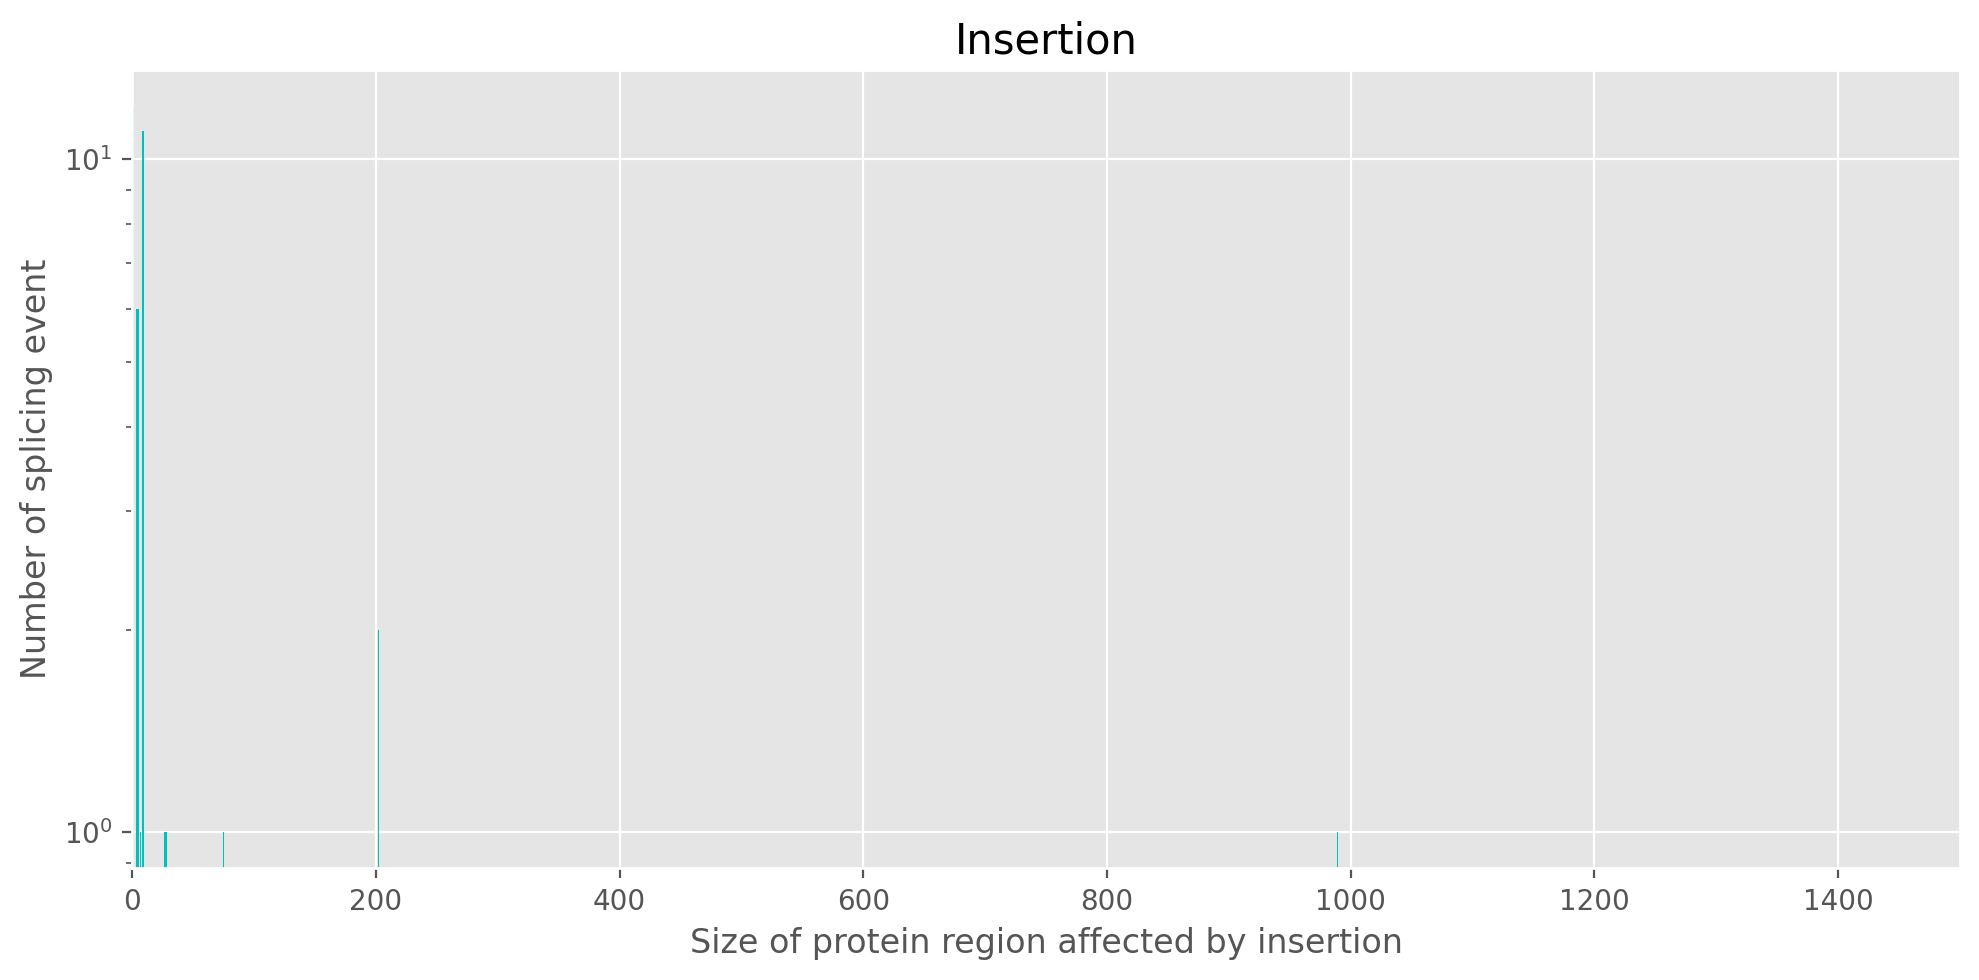

In [61]:
counter = collections.Counter(pb_stats_size_I)
#print(counter)
xi = list(counter.keys())
yi = list(counter.values())

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Insertion", fontsize=15)
plt.xlabel('Size of protein region affected by insertion')
plt.ylabel('Number of splicing event')

plt.bar(xi, yi, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_I.png',dpi=1200)


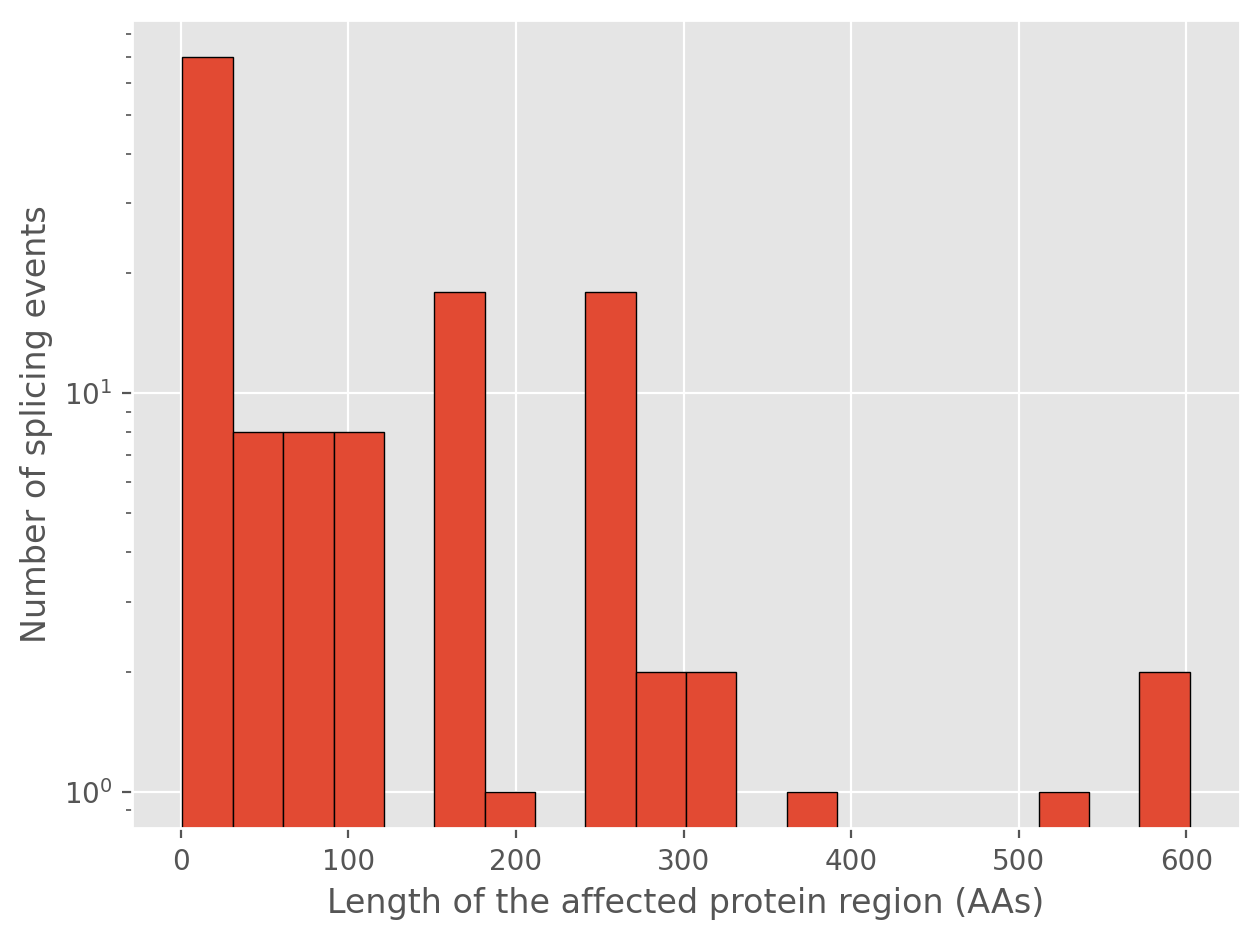

In [66]:
plt.hist(pb_stats_size_D, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 4: Size of affected protein regions vs number of isoform aggregate plot for deletion splice event
To see what's the size of the pblocks being affected per isoform


In [62]:
wb = op.load_workbook(r'merged_file.xlsx')

In [63]:
pb_stats_size_D=[]


def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        # print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
        size = res[3]-res[2]
    elif c1_pb_val.startswith("D"):
        pb_stats_size_D.append(size)
    #print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
    return 0

for sh in wb.worksheets:

    for i in range(2, sh.max_row):
        c1_ref = sh.cell(row=i, column=2)
        c2_ref =sh.cell(row=i, column=2)
        c1_iso = sh.cell(row=i, column=3)
        c2_iso = sh.cell(row=i+1, column=3)
        c1_pb = sh.cell(row=i, column=10)
        c2_pb = sh.cell(row=i+1, column=10)
        #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # When iso are same
        if c1_iso.value == c2_iso.value:
            if c1_pb.value != c2_pb.value:
                #pblock is different for the iso
                #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                getsize(c1_pb.value, sh, c1_iso.value)
        
            #else:
                #print("Same pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                #print(count)
            
        #When iso are different
        else: 
            getsize(c1_pb.value, sh, c1_iso.value)
            
            # pblocks shared between two different transcripts
            # if c1_pb.value == c2_pb.value:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            #print(count)
        
        #print(pb_stats,'\n')

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/3035117186.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


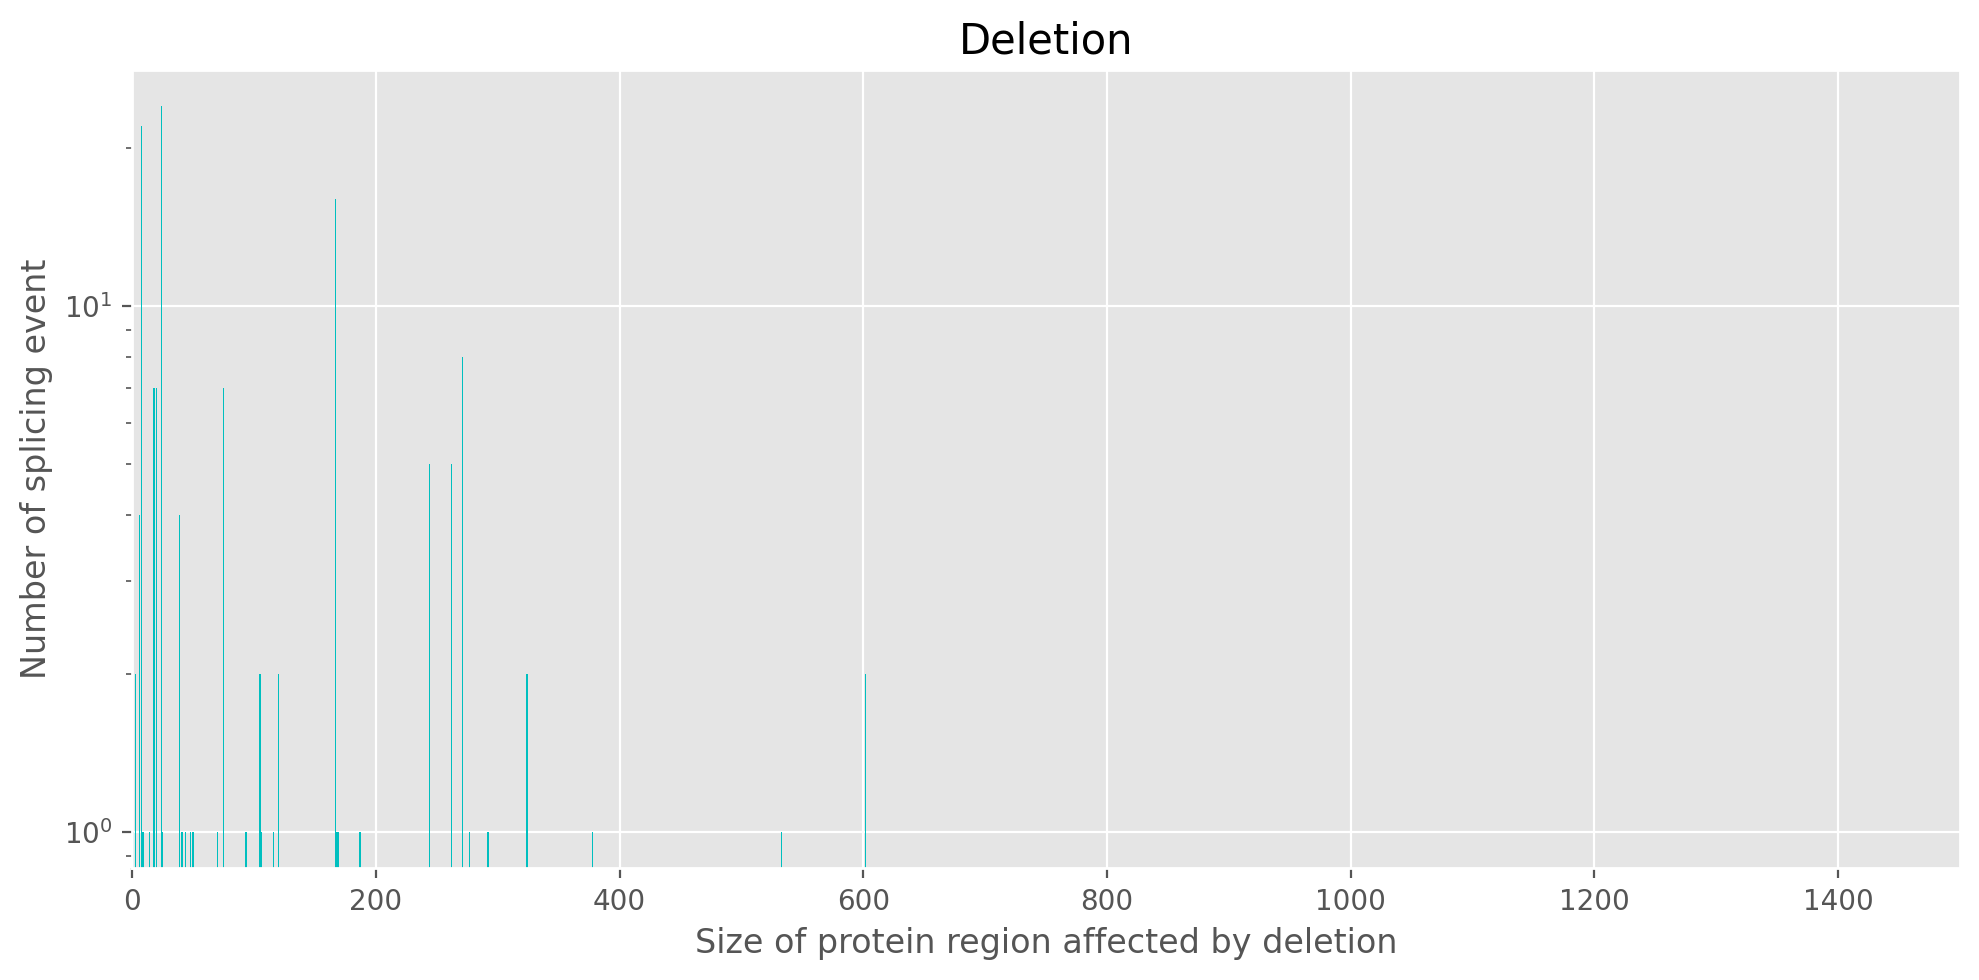

In [64]:
counter = collections.Counter(pb_stats_size_D)
#print(counter)
xd = list(counter.keys())
yd = list(counter.values())


#D

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Deletion", fontsize=15)
plt.xlabel('Size of protein region affected by deletion')
plt.ylabel('Number of splicing event')

plt.bar(xd, yd, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_D.png',dpi=1200)



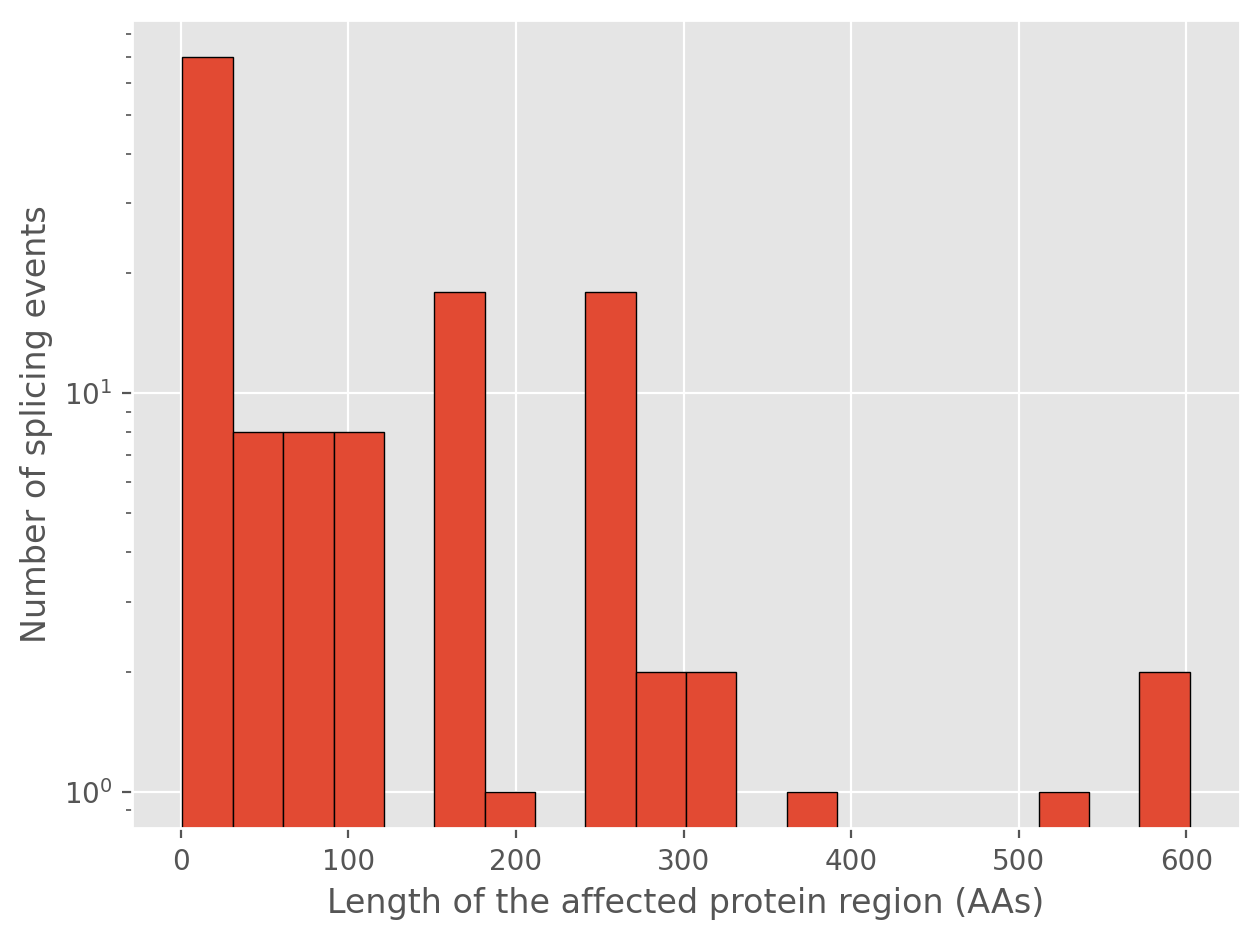

In [65]:
plt.hist(pb_stats_size_D, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 5: Size of affected protein regions vs number of isoform aggregate plot for substitution splice event
To see what's the size of the pblocks being affected per isoform


In [68]:
wb = op.load_workbook(r'merged_file.xlsx')

In [69]:
pb_stats_size_S=[]


def getsize(c1_pb_val, sh, c1_iso_val):
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size = res[1]-res[0]
    if  size == 0:
        # print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
        size = res[3]-res[2]

    elif c1_pb_val.startswith("S"):
        pb_stats_size_S.append(size)
    #print(sh, " : ", c1_iso_val, " : ", c1_pb_val, " : " ,str(res)," : ", size)
    return 0

for sh in wb.worksheets:

    for i in range(2, sh.max_row):
        c1_ref = sh.cell(row=i, column=2)
        c2_ref =sh.cell(row=i, column=2)
        c1_iso = sh.cell(row=i, column=3)
        c2_iso = sh.cell(row=i+1, column=3)
        c1_pb = sh.cell(row=i, column=10)
        c2_pb = sh.cell(row=i+1, column=10)
        #print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

        # When iso are same
        if c1_iso.value == c2_iso.value:
            if c1_pb.value != c2_pb.value:
                #pblock is different for the iso
                #print("Different pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)

                getsize(c1_pb.value, sh, c1_iso.value)
   
        
            #else:
                #print("Same pb for same iso ",c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
                #print(count)
            
        #When iso are different
        else: 
            getsize(c1_pb.value, sh, c1_iso.value)

            
            # pblocks shared between two different transcripts
            # if c1_pb.value == c2_pb.value:
            #     print(c1_iso.value, c1_pb.value, c2_iso.value, c2_pb.value)
            #print(count)
        
        #print(pb_stats,'\n')

/var/folders/yj/q7ccjqsx2rg2czn92rx0_8sc0000gn/T/ipykernel_2152/820489383.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', quality=1200)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


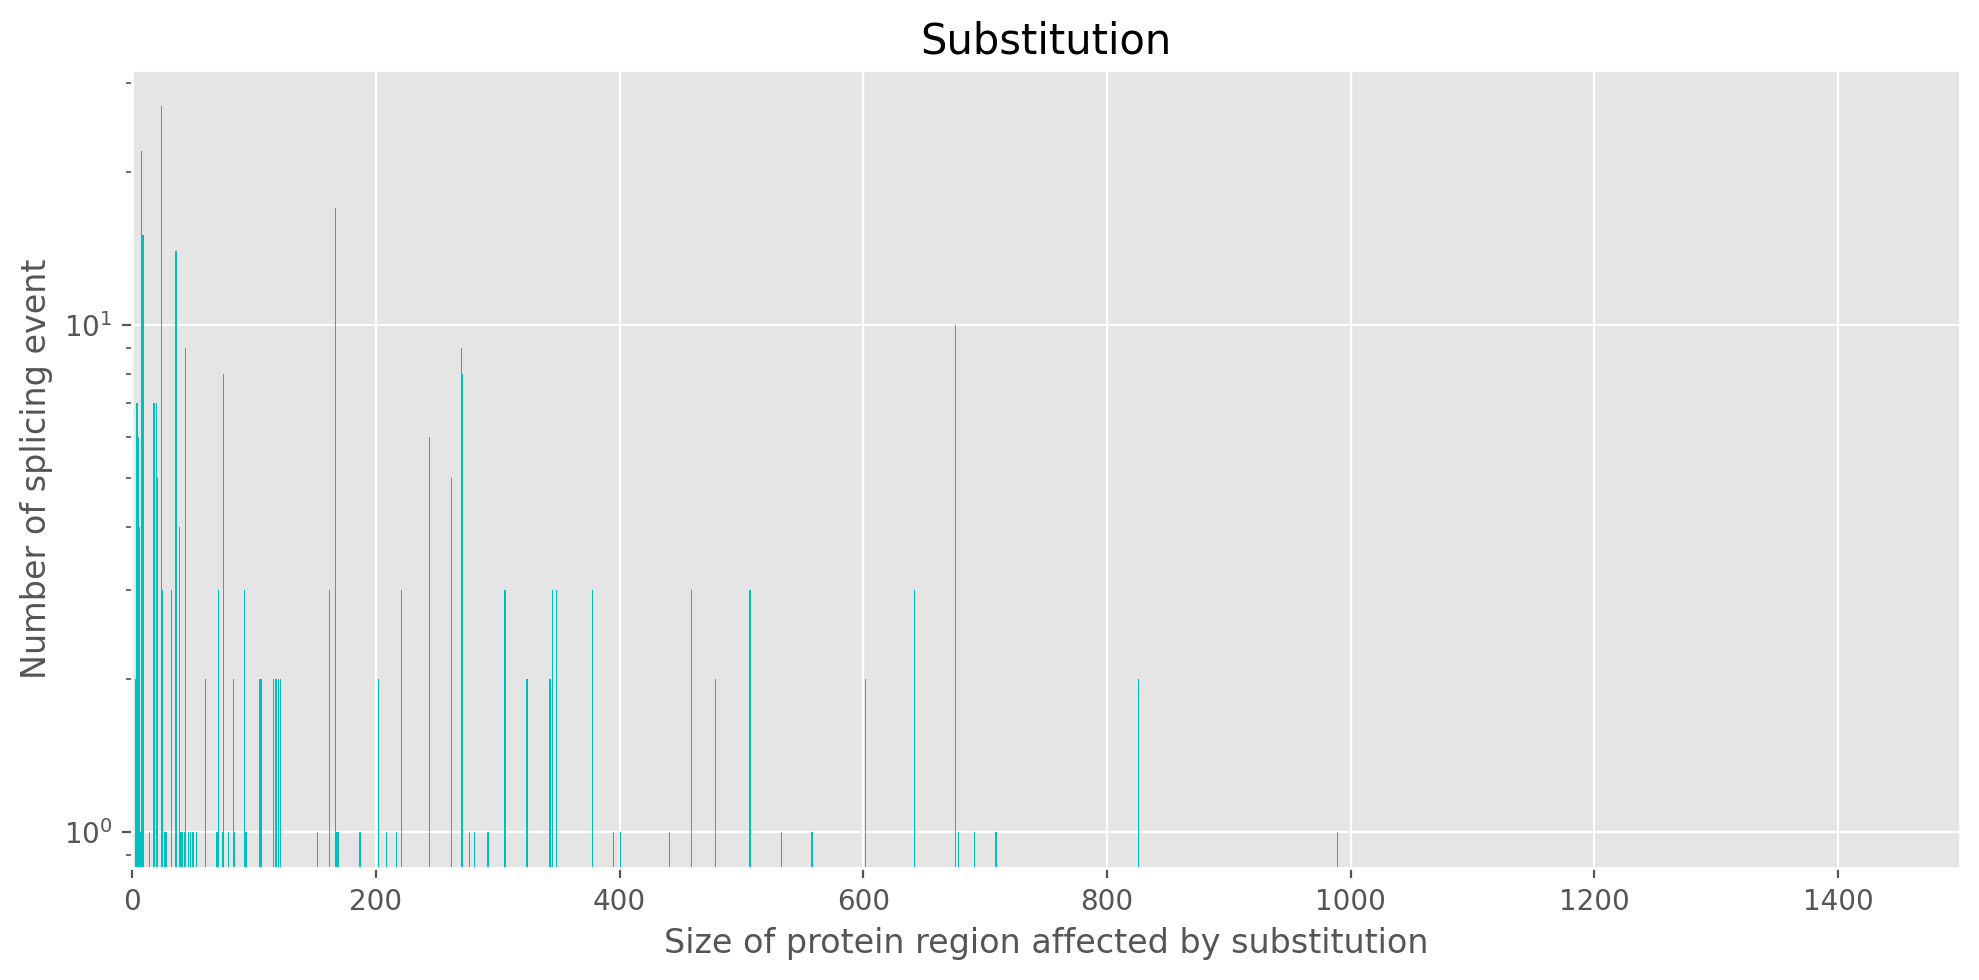

In [71]:

counter = collections.Counter(pb_stats_size_S)
#print(counter)
xs = list(counter.keys())
ys = list(counter.values())


#S

set_matplotlib_formats('retina', quality=1200)
plt.rcParams["figure.autolayout"] = True
plt.style.available
plt.style.use('ggplot')


plt.figure(figsize=(10,5))
plt.yscale('log')
plt.xlim(0,1500)
#plt.yticks([10 * i for i in range(11)])
# #avg line
# plt.axhline(mean_val, color='red', linestyle='dotted', linewidth=1)
plt.title("Substitution", fontsize=15)
plt.xlabel('Size of protein region affected by substitution')
plt.ylabel('Number of splicing event')

plt.bar(x1, y1, width=1, color='c')
fig = plt.gcf()
fig.tight_layout()
plt.show()

#Saving figure
fig.savefig('../../C_toy_plots/isoform_pblock_size_histogram_S.png',dpi=1200)

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


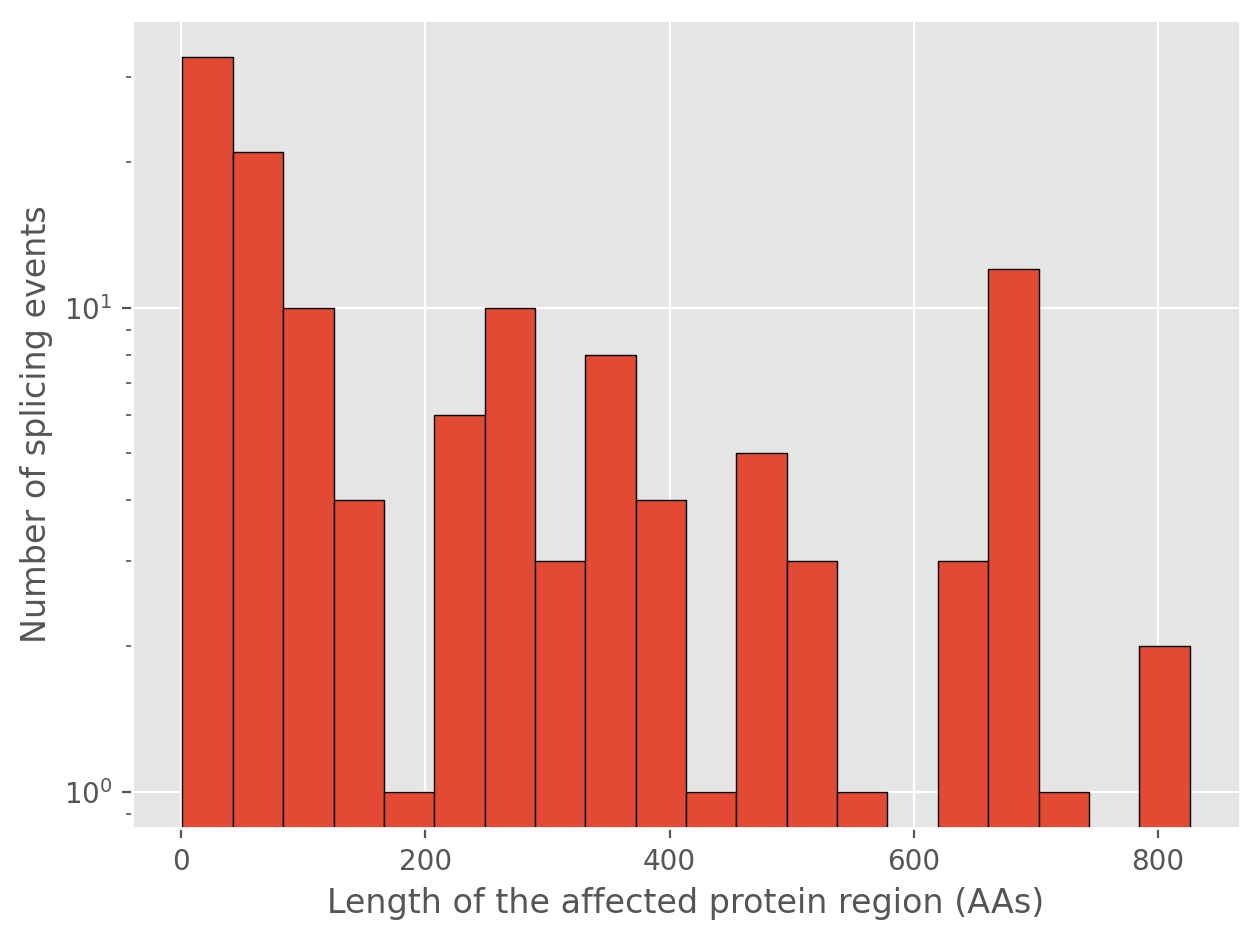

In [72]:
plt.hist(pb_stats_size_S, bins=20, edgecolor='black')
plt.xlabel('Length of the affected protein region (AAs)')
plt.ylabel('Number of splicing events')
plt.yscale('log')
plt.show()

### Plot 6: Number of isoforms vs count of splice events affecting protein region plot for ragged and clean I/D/S

In [74]:
wb = op.load_workbook(r'merged_file.xlsx')

In [75]:
# sh = wb.active

ref_s=[]
alt_s=[]

def getsize(c1_pb_val):
    print(c1_pb.value)
    temp = re.findall(r'\d+', c1_pb_val)
    res = list(map(int, temp))
    size_ref = res[1]-res[0]
    size_alt = res[3]-res[2]
    ref_s.append(size_ref)
    alt_s.append(size_alt)
    return 0

for sh in wb.worksheets:

    for i in range(2, sh.max_row):
        c1_pb = sh.cell(row=i, column=9)
        c2_pb = sh.cell(row=i+1, column=9)
        # print(c1_pb.value, c2_pb.value)
            
        if c1_pb.value != c2_pb.value:
            if c1_pb.value.startswith("S"):
                getsize(c1_pb.value)
        

/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)


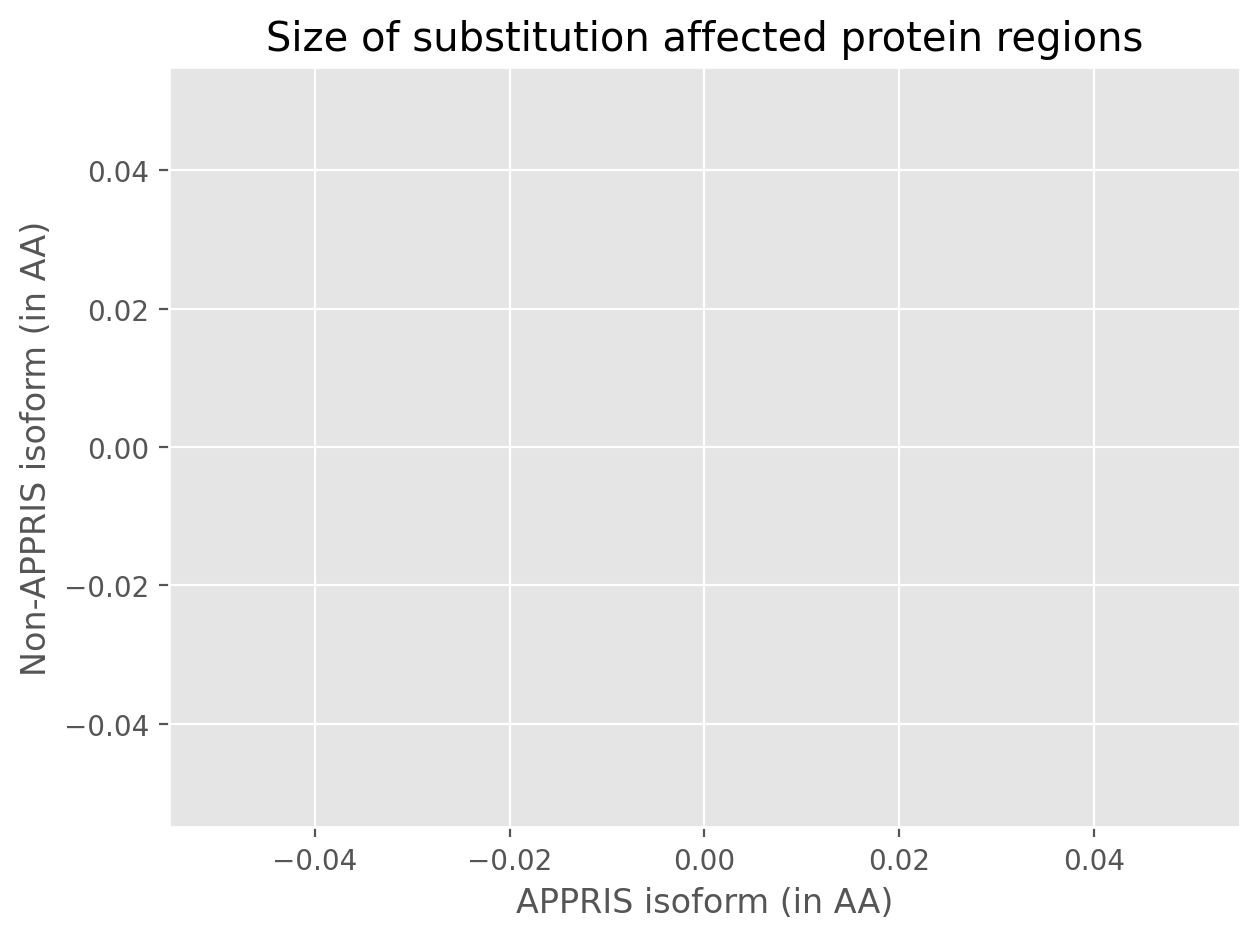

In [77]:

plt.style.use('ggplot')
plt.scatter(ref_s,alt_s)
plt.xlabel('APPRIS isoform (in AA)')
plt.ylabel('Non-APPRIS isoform (in AA)')
plt.title('Size of substitution affected protein regions')

plt.show()
#Saving figure
fig.savefig('../../C_toy_plots/isoform_substitution_categories.png',dpi=1200)